# **Jacob Shearer - Final Project: Digital Signal Processing**

In [1]:
import random
import numpy as np
import scipy.fft as fft
import scipy.stats as stats
import matplotlib.pyplot as plt

## **1 - Introduction**

A digital signal is a way of representing a set of data as a sequence of discrete values. There are many different types of digital signals, but in physics the digital signals that we often see are digitized versions of analog signals from instruments–audio signals from microphones, radio signals from radio receivers, and voltage signals from photomultiplier tubes are a few common examples, among countless others. An analog signal (which is continuous in time) can be converted to a digital signal (which is discrete in time) by sampling the analog signal at evenly-spaced time intervals which are determined by the sampling rate (or sampling frequency, as it is sometimes called). Any time-continuous signal can be accurately recreated by these samples as long as the sampling rate ($f_s$) is greater than or equal to two times the largest frequency ($\omega$) found in the signal (Lai, 2003), a requirement typically referred to as the Nyquist criterion:
</br>
</br>
$$ f_s \geq 2\omega$$
</br>
So, as long as we sample our analog signal according to this criterion, we can be sure that our digital signal is a faithful recreation of the original. 
</br>
</br>
There are many excellent reasons to digitize a signal in this manner, but one of the most important is the fact that digital signals can be digitally processed using a computer. Analog signals are susceptible to noise from a variety of sources (electrical interference, thermal noise, etc.), which means that, by extension, analog-sampled digital signals are susceptible to noise as well. Before the advent of digital signal processing our only recourse for dealing with this noise would have been to filter it out of the analog signal itself with real, analog filters: electronic devices constructed with resistors, capacitors, and inductors. These devices had many limitations which made them quite inconvenient to use, namely that they required constant maintenance and care and performed poorly with very low and very high frequencies (Taylor, 2002). Fortunately, though, advances in computer technology in the mid twentieth century and the invention of an important algorithm, the fast Fourier transform algorithm, made it possible to replace analog filters with digital filters, which are essentially just computer algorithms (Taylor, 2002). This made digital signal processing possible, and therefore made signal processing much easier and cheaper (digital filters don’t need maintenance and cost basically nothing). 
</br>
</br>
Many of these digital filters rely on a mathematical technique called a Fourier transform (which I mentioned a little earlier with the fast Fourier transform algorithm). These will be discussed in more detail in the next section, but essentially they allow a function of time to be decomposed into its frequency components, yielding a function of frequency. Aside from digital signal processing there are many different physics applications (and beyond) that the Fourier transform is useful for, but here are two that are especially significant:

- EM waves are basically just superpositions of plane waves, and so Fourier transforms can be used to determine the constituent frequency of each plane wave
- Quantum Mechanical wavefunctions can be transformed from the spatial domain to the momentum domain using Fourier transforms

In this project I’ll be using the Fourier transform to explore digital signal processing and, more specifically, the removal of noise from a digital signal using digital filters. To that end, I’ll start by exploring and implementing the discrete analogue of a Fourier transform (just the basic DFT, not the FFT). Next I’ll look at two different kinds of digital noise-reduction techniques: the autocorrelation technique–which relies on the non-correlation of noise over long time periods to remove noise–and the windowed-sinc filter–which operates by cutting out the frequencies of a noisy signal that correspond to the noise. Finally I’ll explore how the efficacy of these two filters changes as the severity of the noise increases. I expect that, in general, the windowed-sinc filter will do a better job of removing noise than the autocorrelation filter, but that both will become significantly less effective as the noise gets worse. 

## **2 - Methods**

**2.1 - Fourier Transforms and Discrete Fourier Transforms**

The Fourier transform of an even function $y_e(t)$ can be expressed by the Fourier sine transform:
<br/>
<br/>
$$ Y(\omega) = \sqrt{\frac{2}{\pi}}\int_{0}^{\infty} y_e(t) \sin(\omega t)dt$$
<br/>
Similarly, the Fourier transform of an odd function $y_o(t)$ can be expressed by the Fourier cosine transform:
<br/>
<br/>
$$ Y(\omega) = \sqrt{\frac{2}{\pi}}\int_{0}^{\infty} y_o(t) \cos(\omega t)dt$$
<br/>
For a more general function $y(t)$ we can use complex numbers to express the Fourier transform in terms of complex exponentials:
<br/>
<br/>
$$ Y(\omega) = \frac{1}{\sqrt{2\pi}}\int_{-\infty}^{\infty} y(t) e^{-i\omega t}dt$$
<br/>
And the inverse Fourier transform:
<br/>
<br/>
$$ y(t) = \frac{1}{\sqrt{2\pi}}\int_{-\infty}^{\infty} Y(\omega) e^{i\omega t}d\omega$$
<br/>
where the factor of $\frac{1}{\sqrt{2\pi}}$ is a normalization constant (Boas, 2006). These formulas give the Fourier transform and inverse Fourier transform for a continuious function in the time domain (i.e. a time-continuious signal), but for our digital signal (which is discrete in time) we can't sum over an infinite number of infinitesimal time steps. Thus, we make two approximations:

- The integral becomes a sum that is evaluated from $t = 0$ to $t = T$ (the period over which our digital signal is measured), and; 
- We use the trapezoidal numerical integration rule to carry out the integration

Therefore, the discrete Fourier transform is given by 
</br>
</br>
$$Y_n = \sum_{k=1}^{N} hy_k\frac{e^{-i\omega_n t_k}}{\sqrt{2\pi}} = \sum_{k=1}^{N} y_k e^{-2\pi ikn/N}$$
</br>
And the discrete inverse Fourier transform is given by
</br>
</br>
$$ y_n = \sum_{n=1}^{N} Y_k e^{2\pi ikn/N}$$
<br/>
Where $N$ is the total number of samples, $n$ is the current sample, $k$ is the current frequency, and $h$ is the sample size, or the inverse of the sample rate (Landau et al, 2015; Bayen et al., 2020). The frequencies $\omega_n$ that the DFT uses as bins are given by:
</br>
</br>
$$\omega_n = \frac{2\pi n}{Nh} \text{ (in rad/s)}$$
</br>
or
$$\omega_n = \frac{n}{Nh} \text{ (in Hz)}$$
</br>
where, due to the nature of the transform, the bins corresponding to $Y_1, Y_2, \ldots, Y_{N/2-1}$ contain the positive frequencies and the bins corresponding to $Y_{N/2}, \ldots, Y_{N-1}$ contain the negative frequencies, in order of decreasingly negative frequency, for an even $N$. For a real-valued function $y(t)$ (i.e. a real signal) all of these negative frequencies are simply mirror images of their positive counterparts (Bayen et al., 2020). I've implemented the DTF and DIFT in Section 3.1 and I've used an even number of samples throughout the project.

**2.2 - Noise Filtering via Autocorrelation**

Noise filtering via autocorrelation makes use of the correlation function, which is a way of measuring the correlation between two functions $x(t)$ and $y(t)$:
</br>
</br>
$$c(\tau) = \int_{-\infty}^{\infty} y^*(t)x(t+\tau) \text{ }dt = \int_{-\infty}^{\infty} y^*(t-\tau)x(t) \text{ }dt$$
</br>
where $\tau$ is the lag time between the two functions. We assume that our noisy signal ($y(t)$) is essentially just a combination of the pure signal ($s(t)$) and some noise ($n(t)$):
</br>
</br>
$$ y(t) = s(t) + n(t)$$
</br>
and therefore the *autocorrelation* of the noisy signal (the correlation of the noisy signal with itself) is given by
</br>
</br>
$$A_y(\tau) = \int_{-\infty}^{\infty} y(t)y^*(t-\tau) \text{ }dt$$
</br>
$$ = \int_{-\infty}^{\infty} (s(t) + n(t))(s^*(t-\tau) + n^*(t-\tau)) \text{ }dt$$
</br>
$$ = \int_{-\infty}^{\infty} s(t)s^*(t-\tau) + s(t)n^*(t-\tau) + n(t)s^*(t-\tau) + n(t)n^*(t-\tau) \text{ }dt$$
</br>
Because noise is random, it should be uncorrelated with the signal and itself over long periods of time. Therefore, all of the terms in the above integral that include $n(t)$ or its complex conjugate go to zero, and we are left with the autocorrelation of the pure signal:
</br>
</br>
$$A_y(\tau) = \int_{-\infty}^{\infty} s(t)s^*(t-\tau) \text{ }dt = A_s(\tau)$$
</br>
Finally, the autocorrelation of a signal is related to the signal's power spectrum by a Fourier transform:
</br>
</br>
$$FT(A_s(\tau)) = A(\omega) = \sqrt{2\pi}|S(\omega)|^2$$
</br>
So, by computing the autocorrelation of a noisy signal and taking its Fourier transform we can obtain the power spectrum of the pure signal (multiplied by a factor $\sqrt{2\pi}$). I've implemented a discrete version of the autocorrelation function and used it to denoise a signal in Section 3.3. 

**2.3 - The Windowed-Sinc Filter**

The windowed-sinc filter is what's known as a low-pass filter: only frequencies below a certain cutoff, $w_c$ (which is a fraction of the sampling rate (Smith, 1997)), will be allowed through. This filter criteria is based on the fact that noise is generally comprised of high-frequency components, and that by cutting out these components we can remove the noise from the signal. In the frequency domain, the filter is essentially just a rectangle of unit height, centered at the origin:
</br>
</br>
$$ \text{rect}(\omega)=   \left\{
\begin{array}{ll}
      1, \text{ if } |\omega| \le 1/2 \\
      0, \text{ if } |\omega| > 1/2 \\
\end{array} 
\right.  $$
</br>
where we define
</br>
</br>
$$H(\omega, \omega_c) = \text{rect}(\frac{\omega}{2\omega_c})$$
</br>
In the time domain, this function is proportional to the sinc function:
</br>
</br>
$$FT(H(\omega, \omega_c)) = h(t) = \text{sinc}(\omega_c t) = \frac{\sin(\omega_c t)}{\omega_c t}$$
</br>
Producing an *exactly* rectangular response from this function in the frequency domain would require an infinite number of samples (Smith, 1997), which we can't do. Therefore, we make a few approximations:

- We sample the function at (M+1) points located symmetrically about the main lobe of $\sin(\pi t)/\pi t$, and;
- we shift all times to positive values

These adjustments produce the discrete version of the filter:
</br>
</br>
$$ h[i] = \frac{\sin(2\pi \omega_c (i- M/2))}{i - M/2}, \text{ } 0 \le t \le M$$
</br>
Making these adjustments results in some Gibbs overshoot (unwanted oscillations), but we reduce this by multiplying by a smoothing function called the Hamming Window function:
</br>
</br>
$$ w[i] = 0.54 - 0.46\cos(2\pi i /M)$$
</br>
which leaves us with the final filter kearnel:
</br>
</br>
$$ h[i] = \frac{\sin(2\pi \omega_c (i- M/2))}{i - M/2} [0.54 - 0.46\cos(2\pi i /M)]$$
</br>
(Smith, 1997). We apply this filter to a noisy signal by convolving it with the signal. But, via convolution theorem, a convolution in the time domain is just a multiplication in the frequency domain, so for a noisy signal $y(t)$:
</br>
</br>
$$s(t) = y(t) * h(t) \rightarrow S(\omega) = FT(y(t)) \cdot FT(h(t)) = Y(\omega) \cdot H(\omega, \omega_c)$$
</br>
Therefore, after convolving the filter and the noisy signal, all we need to do is take the inverse Fourier transform to obtain the denoised signal:
</br>
</br>
$$ s(t) = IFT(S(\omega)) = IFT(FT(y(t) \cdot FT(h(t)))$$
</br>
(Landau et al., 2015). I've implemented this method in Section 3.4. 

## **3 - Results**

**3.1 - Test Signal and DFT**

For this project I've decided to use a linear combination of sine functions as my analogue test signal (maybe it's a signal from an oscilloscope or something), sampled at a rate of 80Hz:
</br>
</br>
$$ s(t) = \sin(4t) + \sin(5t) + \sin(6t)$$
</br>
Each sine function has a different frequency: 4 rad/s (4/2π Hz), 5 rad/s (5/2π Hz), and 6 rad/s (6/2π Hz). Since we are sampling the function at 80 Hz, we easily satisfy the Nyquist criterion. Below is a plot of the digital test signal and the code used to produce it:

In [2]:
def test_signal(n_sample_points, sample_rate):
    sample_spacing = 1/sample_rate
    sampling_times = np.linspace(0.0, n_sample_points*sample_spacing, n_sample_points)
    A = 1
    analog_signal = lambda t:A*(np.sin(4*t) + np.sin(5*t) + np.sin(6*t))
    digital_signal = analog_signal(sampling_times)
    return sampling_times, digital_signal

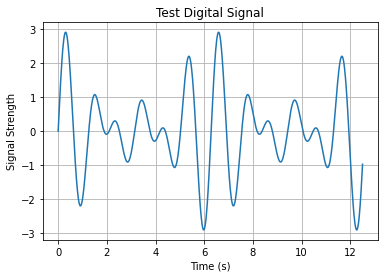

In [3]:
n_sample_points = 1000
sample_rate = 80
times, signal = test_signal(n_sample_points, sample_rate)
plt.plot(times, signal)
plt.xlabel('Time (s)')
plt.ylabel('Signal Strength')
plt.title('Test Digital Signal')
plt.grid()
plt.show()

I've also implemented the DFT and the DIFT exactly as described by the equations in Section 2.1:

In [4]:
def FT(sample_rate, signal):
    signal_ft = np.array([])
    N = len(signal)
    k_array = np.arange(0, N, 1)
    for k in k_array:
        ftsum = 0
        for n in range(N):
            ftsum += signal[n] * np.e**((1j*2*np.pi*k*n)/N)
        
        signal_ft = np.append(signal_ft, ftsum)
        
    n = np.arange(N)
    T = N/sample_rate
    frequencies = n/T
    negative_part = frequencies[int(N/2):]
    frequencies = np.append(frequencies[:int(N/2)], frequencies[int(N/2)-1] - negative_part[::-1])
    return frequencies, signal_ft

In [5]:
def IFT(signal_ft):
    ift = np.array([])
    N = len(signal_ft)
    n_array = np.arange(0, N, 1)
    for n in n_array:
        iftsum = 0
        for k in range(N):
            iftsum += signal_ft[k] * np.e**((-1j*2*np.pi*k*n)/N)
        
        iftsum = iftsum/N
        ift = np.append(ift, iftsum)
    
    ift = np.real(ift)
    return ift

Using this code to take the DFT of the test signal we can obtain the signal's power spectrum, which is defined below:
</br>
</br>
$$\text{power spectrum} = |S(\omega)|^2$$
</br>
The signal's power spectrum is pretty much exactly what it sounds like: a way of measuring the power of each of a signal's frequency components. The test signal's spectrum is plotted below. 

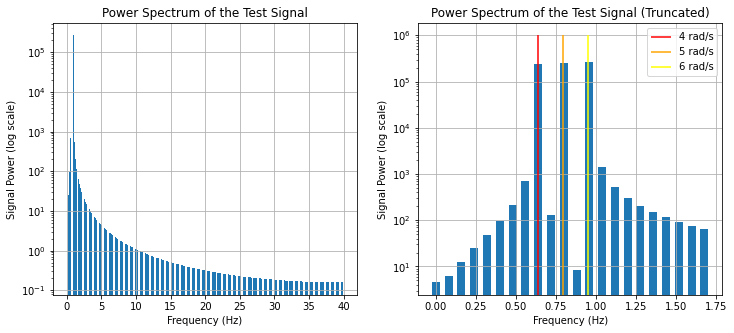

In [6]:
frequencies, signal_fft = FT(sample_rate, signal)
power_spectrum = np.abs(signal_fft)**2

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 5))

# Cutting out the negative frequencies because, for the FT of real-valued functions, all of these negative frequencies 
# are mirror images of their positive counterparts.
ax1.bar(frequencies[:int(len(frequencies)/2)], power_spectrum[:int(len(frequencies)/2)], width=0.05)
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Signal Power (log scale)')
ax1.set_yscale('log')
ax1.set_title('Power Spectrum of the Test Signal')
ax1.grid()

ax2.bar(frequencies[:int(len(frequencies)/45)], power_spectrum[:int(len(frequencies)/45)], width=0.05)
ax2.vlines([4/(2*np.pi)], 0, 1e6, colors=('r'), label='4 rad/s')
ax2.vlines([5/(2*np.pi)], 0, 1e6, colors=('orange'), label='5 rad/s')
ax2.vlines([6/(2*np.pi)], 0, 1e6, colors=('yellow'), label='6 rad/s')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Signal Power (log scale)')
ax2.set_yscale('log')
ax2.legend()
ax2.set_title('Power Spectrum of the Test Signal (Truncated)')
ax2.grid()
plt.show()

As the rightmost plot shows, the largest values in the power spectrum are located at the frequencies that I used for each sine function. 

Using the DIFT, we can also obtain the original test signal from it's Fourier transform, as demonstrated below:

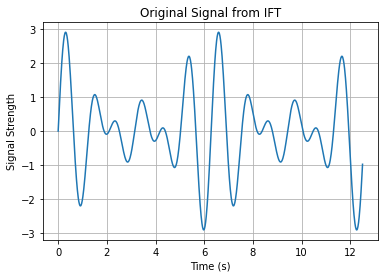

In [7]:
original_signal = IFT(signal_fft)
plt.plot(times, original_signal)
plt.xlabel('Time (s)')
plt.ylabel('Signal Strength')
plt.title('Original Signal from IFT')
plt.grid()
plt.show()

As promised, this is exactly the same as the original. 

**3.2 - Noisy Test Signal**

Below is the code that adds noise to the test signal, making a noisy test signal. I've used pseudo-random, Gaussian-distributed noise (sometimes referred to as "white noise") with an amplitude of 0.2 for this part of the project. 

In [8]:
def add_noise(signal, noise_amplitude, seed_n=None):
    if seed_n is not None:
        np.random.seed(seed_n)
    
    noise_function = lambda: noise_amplitude*np.random.normal(0, 1)
    noisy_signal = np.zeros(len(signal))
    for i in range(len(signal)):
        noisy_signal[i] = signal[i] + noise_function()
    
    return noisy_signal

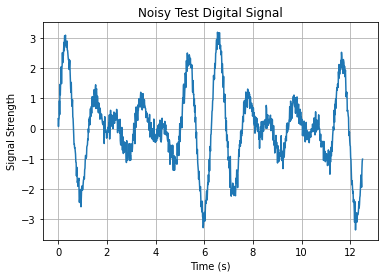

In [9]:
n_sample_points = 1000
sample_rate = 80
times, signal = test_signal(n_sample_points, sample_rate)
seed_n = 1
noise_amplitude = 0.2
noisy_signal = add_noise(signal, noise_amplitude, seed_n)
plt.plot(times, noisy_signal)
plt.xlabel('Time (s)')
plt.ylabel('Signal Strength')
plt.title('Noisy Test Digital Signal')
plt.grid()
plt.show()

As the above plot shows, the original signal's curvature is still kind of recognizable, but the signal is generally much more jagged. We can also compute the noisy signal's power spectrum:

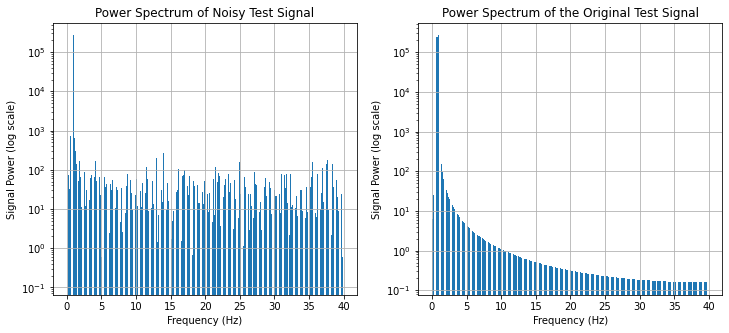

In [10]:
frequencies, noisy_signal_fft = FT(sample_rate, noisy_signal)
noisy_power_spectrum = np.abs(noisy_signal_fft)**2

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 5))

ax1.bar(frequencies[:int(len(frequencies)/2)], noisy_power_spectrum[:int(len(frequencies)/2)], width=0.05)
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Signal Power (log scale)')
ax1.set_yscale('log')
ax1.set_title('Power Spectrum of Noisy Test Signal')
ax1.grid()

ax2.bar(frequencies[:int(len(frequencies)/2)], power_spectrum[:int(len(frequencies)/2)], width=0.05)
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Signal Power (log scale)')
ax2.set_yscale('log')
ax2.set_title('Power Spectrum of the Original Test Signal')
ax2.grid()

plt.show()

Whereas the original signal has a roughly exponentially decreasing frequency spectrum starting at the peak frequencies, the noisy signal has a kind of mesa. Finally, we can also compute the DIFT:

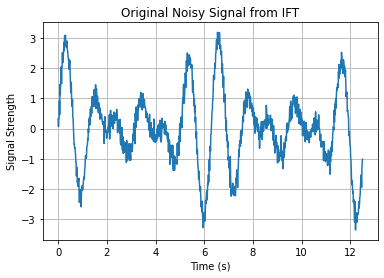

In [11]:
original_noisy_signal = IFT(noisy_signal_fft)
plt.plot(times, original_noisy_signal)
plt.xlabel('Time (s)')
plt.ylabel('Signal Strength')
plt.title('Original Noisy Signal from IFT')
plt.grid()
plt.show()

**3.3 - Noise Filtering via Autocorrelation**

Below I've implemented the discrete autocorrelation:

In [12]:
def autocorrelation(signal):
    length = len(signal)
    autocorrelation_array = []
    for tau in np.arange(0, length):
        correlation = np.sum(signal[:(length-tau)] * signal[tau:])
        autocorrelation_array.append(correlation)
    
    autocorrelation_array = np.array(autocorrelation_array)
    return autocorrelation_array[::-1]

Taking the autocorrelation of the noisy test signal, we obtain the following plot:

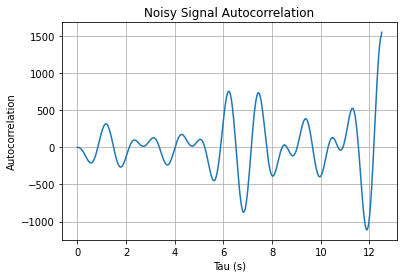

In [13]:
noisy_signal_autoc = autocorrelation(noisy_signal)
plt.plot(times, noisy_signal_autoc)
plt.xlabel('Tau (s)')
plt.ylabel('Autocorrelation')
plt.title('Noisy Signal Autocorrelation')
plt.grid()
plt.show()

This shares some similarities with the original test signal (it almost looks like a flipped, slightly modified version), so it makes sense that we would still be able to obtain the frequency components of the original signal from it. Below we compute the power spectrum from the autocorrelation:

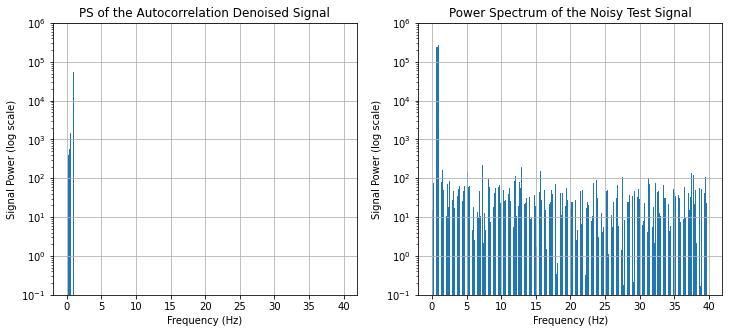

In [14]:
n_sample_points = 1000
sample_rate = 80
autoc_frequencies, autoc_ft = FT(sample_rate, noisy_signal_autoc)
autoc_power_spectrum = np.real(autoc_ft)/np.sqrt(2*np.pi)

fig, [ax1, ax2] = plt.subplots(1,2, figsize=(12, 5))

ax1.bar(autoc_frequencies[:int(len(frequencies)/2)], autoc_power_spectrum[:int(len(frequencies)/2)], width=0.05)
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Signal Power (log scale)')
ax1.set_yscale('log')
ax1.set_ylim(1e-1, 1e6)
ax1.set_title('PS of the Autocorrelation Denoised Signal')
ax1.grid()

ax2.bar(frequencies[:int(len(frequencies)/2)], noisy_power_spectrum[:int(len(frequencies)/2)], width=0.05)
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Signal Power (log scale)')
ax2.set_yscale('log')
ax2.set_ylim(1e-1, 1e6)
ax2.set_title('Power Spectrum of the Noisy Test Signal')
ax2.grid()

plt.show()

The autocorrelation seems to have eliminated the higher frequency mesa, but it also lacks the exponentially decreasing high-frequency components that the original signal had. It does, at least, include the important peak frequency components though. 
</br>
</br>
Unfortunately, this is where our analysis for the autocorrelation method ends. Because the autocorrelation is only directly related to the power spectrum of the original signal, and not the original signal itself, it isn't possible to get the original signal back from this.

**3.4 - Windowed-Sinc Filtering**

Here's my implementation of the windowed-sinc function:

In [15]:
def windowed_sinc(times, cutoff_freq):
    m = len(times)
    filter_array = []
    for i in range(0, m):
        denom = i - m/2
        if denom == 0:
            h = 2*np.pi*cutoff_freq
        else:
            hamming_window = (0.54 - 0.46*np.cos(2*np.pi*(i/m)))
            h = (np.sin(2*np.pi*cutoff_freq*(i-m/2))/denom)*hamming_window
        
        filter_array.append(h)
    
    return filter_array/np.sum(filter_array)

And here's where we make the filter, take the Fourier transform of it and the noisy signal, and convolute the two. Before that, though, I just wanted to plot the filter's power spectrum. 

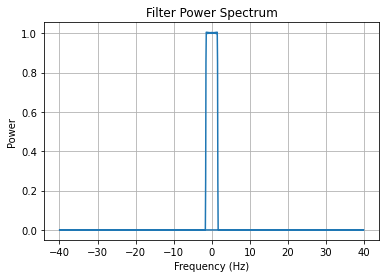

In [16]:
cutoff_freq = 1.6
n_sample_points = 1000
sample_rate = 80
filter_array = windowed_sinc(times, cutoff_freq/sample_rate)
frequencies, filter_ft = FT(sample_rate, filter_array)
frequencies, noisy_signal_ft = FT(sample_rate, noisy_signal)
convolution = filter_ft * noisy_signal_ft
convolution_power_spectrum = np.abs(convolution)**2

plt.plot(frequencies, np.abs(filter_ft)**2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title('Filter Power Spectrum')
plt.grid()
plt.show()

As I said in Section 2.3, it's a rectangle of unit height. If you look closely, you can still see some Gibbs overshoot on the corners, even with the Hamming window. Here's a plot of the noisy signal/filter convolution's power spectrum:

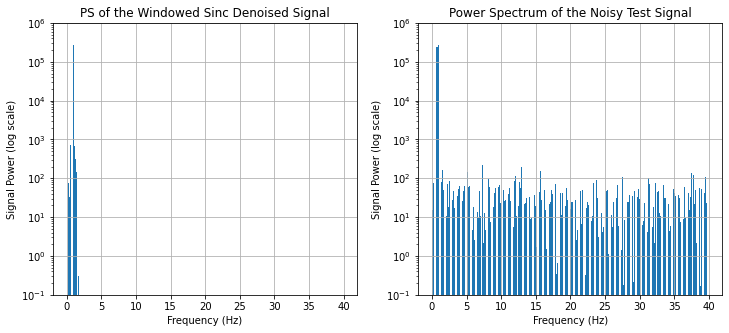

In [17]:
fig, [ax1, ax2] = plt.subplots(1,2, figsize=(12, 5))

ax1.bar(frequencies[:int(len(frequencies)/2)], convolution_power_spectrum[:int(len(frequencies)/2)], width=0.05)
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Signal Power (log scale)')
ax1.set_yscale('log')
ax1.set_ylim(1e-1, 1e6)
ax1.set_title('PS of the Windowed Sinc Denoised Signal')
ax1.grid()

ax2.bar(frequencies[:int(len(frequencies)/2)], noisy_power_spectrum[:int(len(frequencies)/2)], width=0.05)
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Signal Power (log scale)')
ax2.set_yscale('log')
ax2.set_ylim(1e-1, 1e6)
ax2.set_title('Power Spectrum of the Noisy Test Signal')
ax2.grid()

plt.show()

I used a cutoff frequency of 1.6 Hz, and it looks like everything above that frequency is gone, as promised. Similarly to the autocorrelation method, the filter maintains the essential parts, but inevitably some signal (the high-frequency components) are lost. Now we can take the DIFT of the convolution to obtain a denoised version of the original signal:

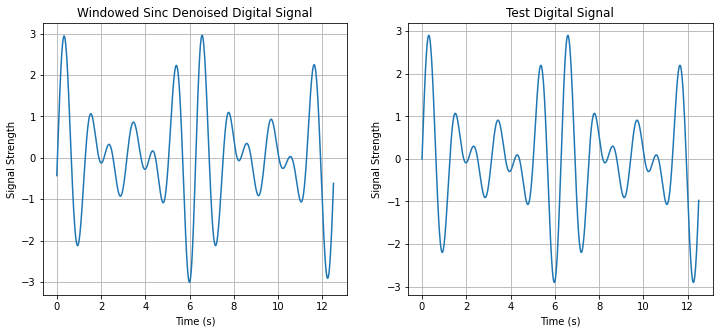

In [18]:
convolution_ift = IFT(convolution)

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(times, convolution_ift)
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Signal Strength')
ax1.set_title('Windowed Sinc Denoised Digital Signal')
ax1.grid()


ax2.plot(times, signal)
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Signal Strength')
ax2.set_title('Test Digital Signal')
ax2.grid()

plt.show()

The denoised signal looks pretty similar to the original, with a few minor differences (more on that later).

**3.5 - Filters at Different Noise Amplitudes**

Below I've aplied the two filtering methods to a noisy signal with different noise amplitudes. I start out with amplitudes that are close to the 0.2 amplitude that I used previously and gradually build up to quite large ones. 

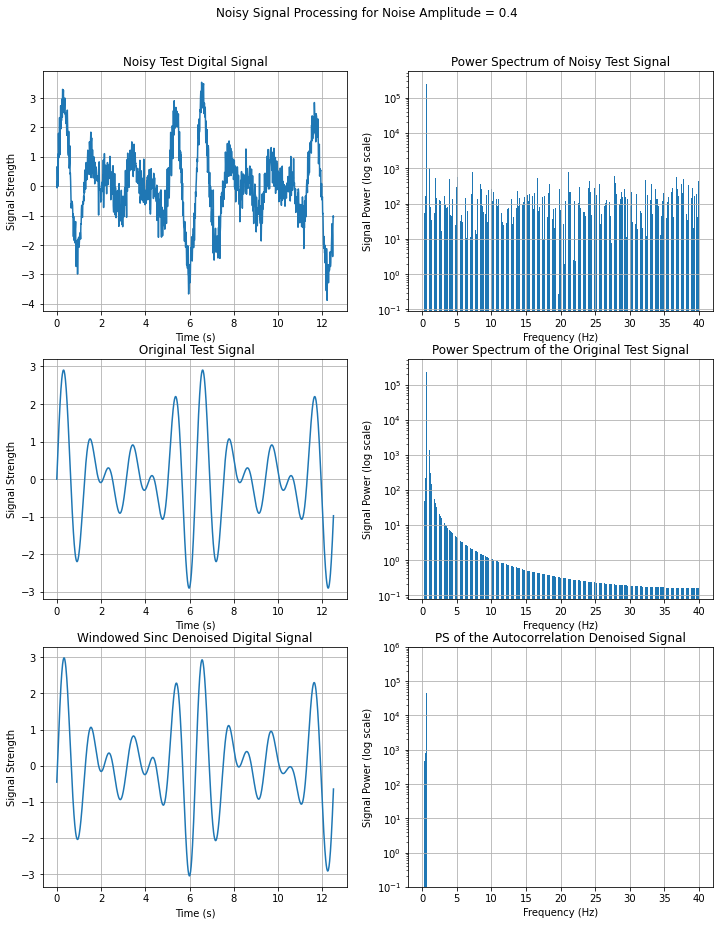

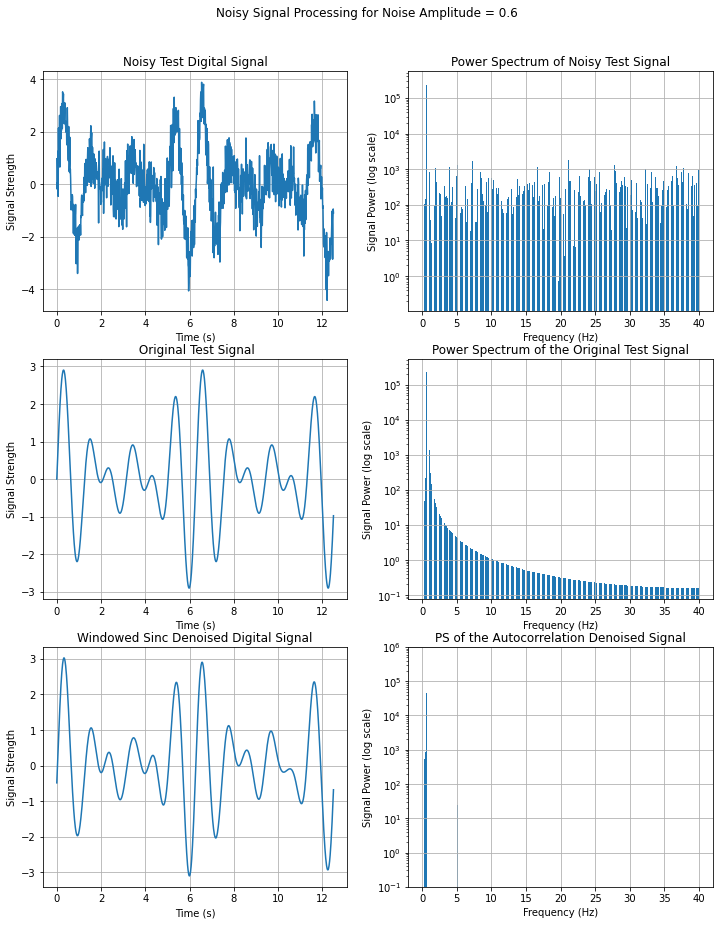

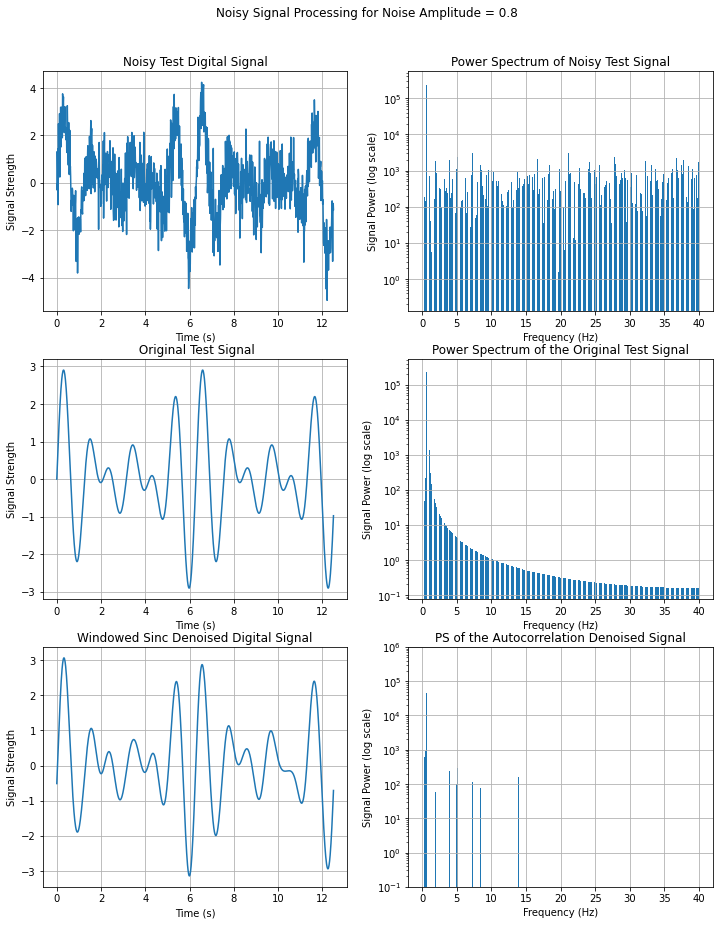

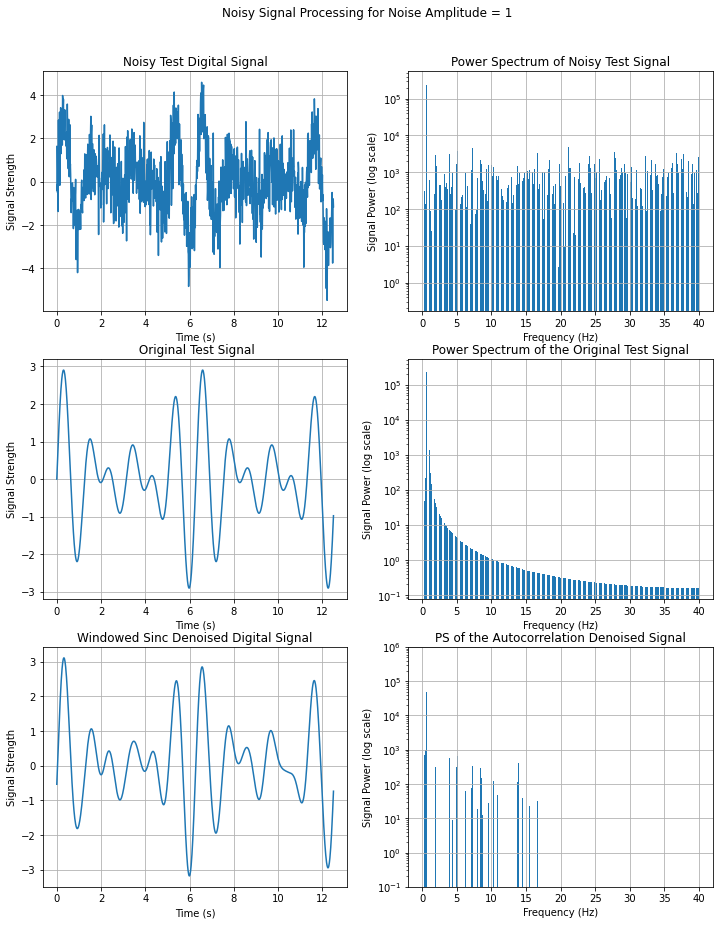

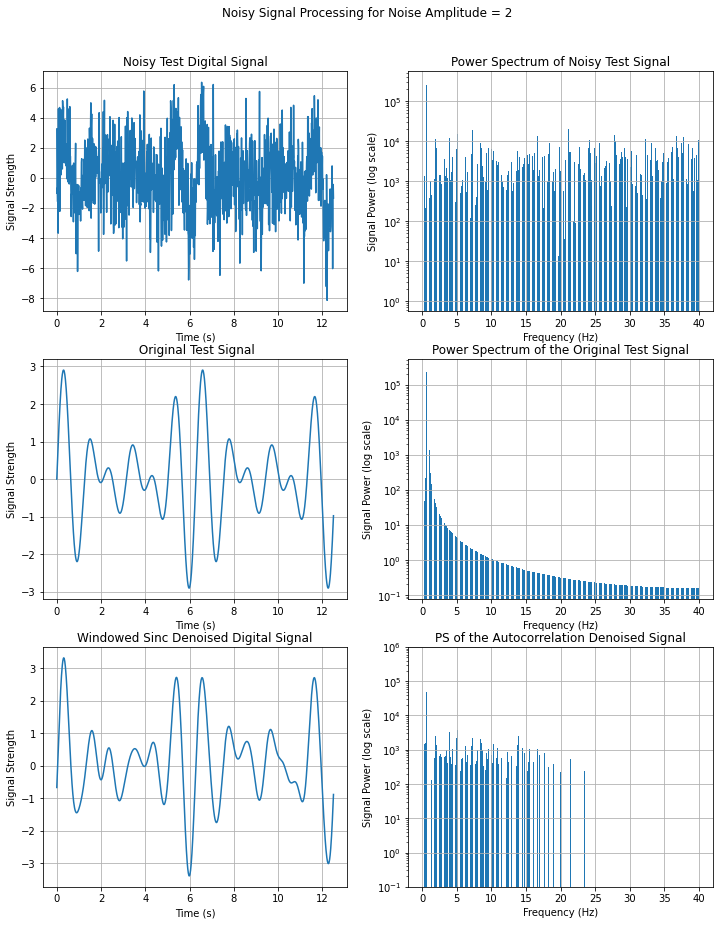

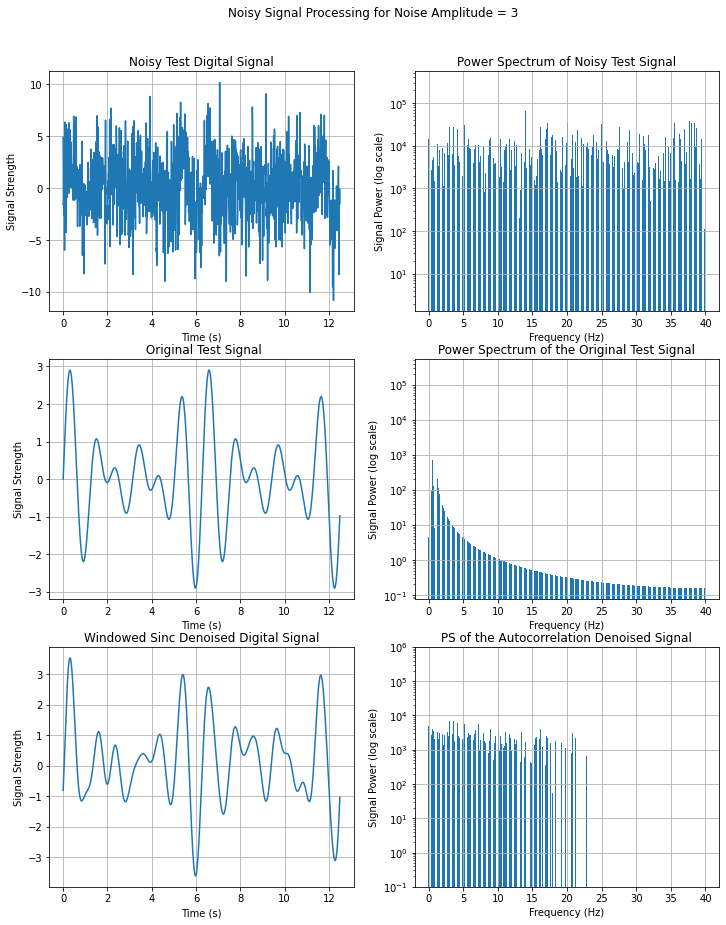

In [19]:
noise_amplitude_list = [0.4, 0.6, 0.8, 1, 2, 3]
cutoff_freq = 1.6
n_sample_points = 1000
sample_rate = 80
for noise_amplitude in noise_amplitude_list:
    # Noisy Signal
    times, signal = test_signal(n_sample_points, sample_rate)
    seed_n = 1
    noisy_signal = add_noise(signal, noise_amplitude, seed_n)
    frequencies, noisy_signal_fft = FT(sample_rate, noisy_signal)
    noisy_power_spectrum = np.abs(noisy_signal_fft)**2
    
    # Autocorrelation
    noisy_signal_autoc = autocorrelation(noisy_signal)
    autoc_frequencies, autoc_ft = FT(sample_rate, noisy_signal_autoc)
    autoc_power_spectrum = np.real(autoc_ft)/np.sqrt(2*np.pi)
    
    # Windowed Sinc
    filter_array = windowed_sinc(times, cutoff_freq/sample_rate)
    frequencies, filter_ft = FT(sample_rate, filter_array)
    frequencies, noisy_signal_ft = FT(sample_rate, noisy_signal)
    convolution = filter_ft * noisy_signal_ft
    convolution_power_spectrum = np.abs(convolution)**2
    convolution_ift = IFT(convolution)
    
    fig, [[ax1, ax2], [ax3, ax4], [ax5, ax6]] = plt.subplots(3, 2, figsize=(12, 15))
    fig.suptitle(f'Noisy Signal Processing for Noise Amplitude = {noise_amplitude}', x=0.5, y=0.94)
    
    ax1.plot(times, noisy_signal)
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Signal Strength')
    ax1.set_title('Noisy Test Digital Signal')
    ax1.grid()
    
    ax2.bar(frequencies[:int(len(frequencies)/2)], noisy_power_spectrum[:int(len(frequencies)/2)], width=0.05)
    ax2.set_xlabel('Frequency (Hz)')
    ax2.set_ylabel('Signal Power (log scale)')
    ax2.set_yscale('log')
    ax2.set_title('Power Spectrum of Noisy Test Signal')
    ax2.grid()
    
    ax3.plot(times, signal)
    ax3.set_xlabel('Time (s)')
    ax3.set_ylabel('Signal Strength')
    ax3.set_title(' Original Test Signal')
    ax3.grid()
    
    ax4.bar(frequencies[:int(len(frequencies)/2)], power_spectrum[:int(len(frequencies)/2)], width=0.05)
    ax4.set_xlabel('Frequency (Hz)')
    ax4.set_ylabel('Signal Power (log scale)')
    ax4.set_yscale('log')
    ax4.set_title('Power Spectrum of the Original Test Signal')
    ax4.grid()
    
    ax5.plot(times, convolution_ift)
    ax5.set_xlabel('Time (s)')
    ax5.set_ylabel('Signal Strength')
    ax5.set_title('Windowed Sinc Denoised Digital Signal')
    ax5.grid()
    
    ax6.bar(autoc_frequencies[:int(len(frequencies)/2)], autoc_power_spectrum[:int(len(frequencies)/2)], width=0.05)
    ax6.set_xlabel('Frequency (Hz)')
    ax6.set_ylabel('Signal Power (log scale)')
    ax6.set_yscale('log')
    ax6.set_ylim(1e-1, 1e6)
    ax6.set_title('PS of the Autocorrelation Denoised Signal')
    ax6.grid()
    
    plt.show()
    print('\n')

As the plots show, the filters do become more ineffective as the noise gets worse. 

## **4 - Discussion**

Overall, I believe that my original hypothesis was correct: the Windowed-Sinc filter is indeed a better-performing noise remover than the autocorrelation method. There are two big reasons for this:

- (1) Windowed-Sinc is more *customizable*: the cutoff frequency can be chosen so that, if one so desired, more of the high frequency components are kept (which might lead to a more faithfully denoised signal), and; 
- (2) The denoised signal can be obtained when denoising with Windowed-Sinc, something which isn't possible with the autocorrelation method

The Windowed-Sinc also seems to perform much better than the autocorrelation method as the noise gets worse. Although both methods start to lose efficacy at a noise amplitude of 0.8 (for our test signal, anyway), the filter method at least maintains a *semblance* of the original signal (though it definitely does degrade), whereas the autocorrelation method picks up many more unwanted high-frequency noise components more quickly. 
</br>
</br>
Next, I was surprised to find that neither filtering method does a very good job of preserving the high-frequency components of the *original* signal. I expected that to be the case for the windowed-sinc filter, seeing as how it deliberately cuts out the high-frequencies, but I didn't expect that for the autocorrelation method. In fact, it seems (qualitatively) like both methods produce essentially the same power spectrum. The upside of this is that it suggests an obvious use case for the autocorrelation method: for the power spectrum only. The windowed-sinc filter requires that you choose a cutoff frequency, which was easy for us because we already knew what the important frequencies of the signal were. But, with a real signal, that might not be the case, so it might be a little easier to use the autocorrelation method when only the power spectrum is needed because it can essentially just be applied fuss free.
</br>
</br>
Finally, I did notice one strange thing while using the windowed-sinc filter. If you look closely you can see that it appears to be offset slightly in comparison with the original signal. Its difficult to know exactly what's causing this, but I have two ideas:

- Somehow related to the remaining Gibbs overshoot
- Some kind of artifact from the DFT algorithm

The first one could be investigated by applying the filter with a different type of window than the Hamming window (or even no window at all) to see if it gets worse/better. The second could be tested by examining the Fourier transform of the original signal and comparing it with the filter convolution. 

## **5 - Conclusion**

During this project I've explored digitial signal processing (more specifically digital signal denoising) via Fourier transforms. I implemented the discrete Fourier transform and discrete inverse Fourier transform and used them to denoise a test digital signal via two methods: the autocorrelation method and windowed-sinc filtering. Denoising with the first method produced a power spectrum with all the important frequencies of the original signal, and denoising using the second method returned a fully denoised version of the original signal. Finally, I applied these two methods to a test signal with increasingly worse noise. Overall, I concluded that the windowed-sinc filter was a better way of denoising a signal. 
</br>
</br>
In the future, it might be interesting to try other filters aside from just the windowed-sinc. As a low-pass filter, windowed-sinc simply cuts out everything above it's cutoff frequency, but a filter that does some kind of weighting for high frequencies might more faithfully denoise the signal. It also might be interesting to try using different noise types other than basic white noise: brown, pink and gray noise all have different properties from white noise and probably would've prodcuced different results. Finally, it would definitely be interesting to apply these filtering techniques to a real digital signal (maybe a digital audio signal or a digital image) rather than an artificially created one. 

## **6 - Bibliography**

Bayen, A., Kong, Q., & Siauw, T. (2020). 24.2 - Discrete Fourier Transform (DFT). In *Python Programming and Numerical Methods*. section, Academic Press.
</br>
</br>
Boas, M. L. (2006). 7 - Fourier Series and Transforms. In *Mathematical Methods in the Physical Sciences* (3rd ed., pp. 378–382). chapter, Wiley.
</br>
</br>
Lai, E. (2005). 2 - Converting Analog to Digital Signals and Vice Versa. In *Practical Digital Signal Processing for Engineers and Technicians* (pp. 14–49). chapter, Elsevier-Newnes. 
</br>
</br>
Landau, R. H., Páez, M. J., & Bordeianu, C. C. (2015). 12 - Fourier Analysis: Signals and Filters. In *Computational Physics*. chapter, Wiley.
</br>
</br>
Smith, S. W. (1997). 16 - Windowed-Sinc Filters. In *The Scientist and Engineer's Guide to Digital Signal Processing* (pp. 285–296). chapter, California Technical Publishing.
</br>
</br>
Taylor, F. J. (2002). Signal Processing, Digital. In *Encyclopedia of Physical Science and Technology* (3rd ed., pp. 737–760). chapter, Academic Press. 